<a href="https://colab.research.google.com/github/Jzchzh/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Project Objective

This project is based on data from a real retail company. It aims to integrate customer data from multiple departments (sales, marketing, customer service, and website behavior) and apply machine learning techniques for customer segmentation. The goal is to help the business achieve:

- **Targeted Marketing** - Improve the ROI of marketing campaigns

- **Customer Experience Personalization** - Reduce customer churn and increase satisfaction

- **Sales Strategy Optimization** – Enhance the efficiency and focus of sales efforts

- **360° Customer View** – Break down data silos and gain a comprehensive understanding of each customer

# 2.Data Collection

In this case, we will need to work with business dapartments to obtain data and consolidate it.

- profile : customer profile
- sales : from the sales team, sales records
- email_campaigns/text_campaigns : from marketing team, the campaigns they made and accepted customers
- cust_service : from the customer service team, customer complain record
- web_visit : from IT, ABC official website visit history

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import warnings
import datetime

from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer

pd.set_option('display.max_columns', None)

if not sys.warnoptions :
  warnings.simplefilter(action="ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


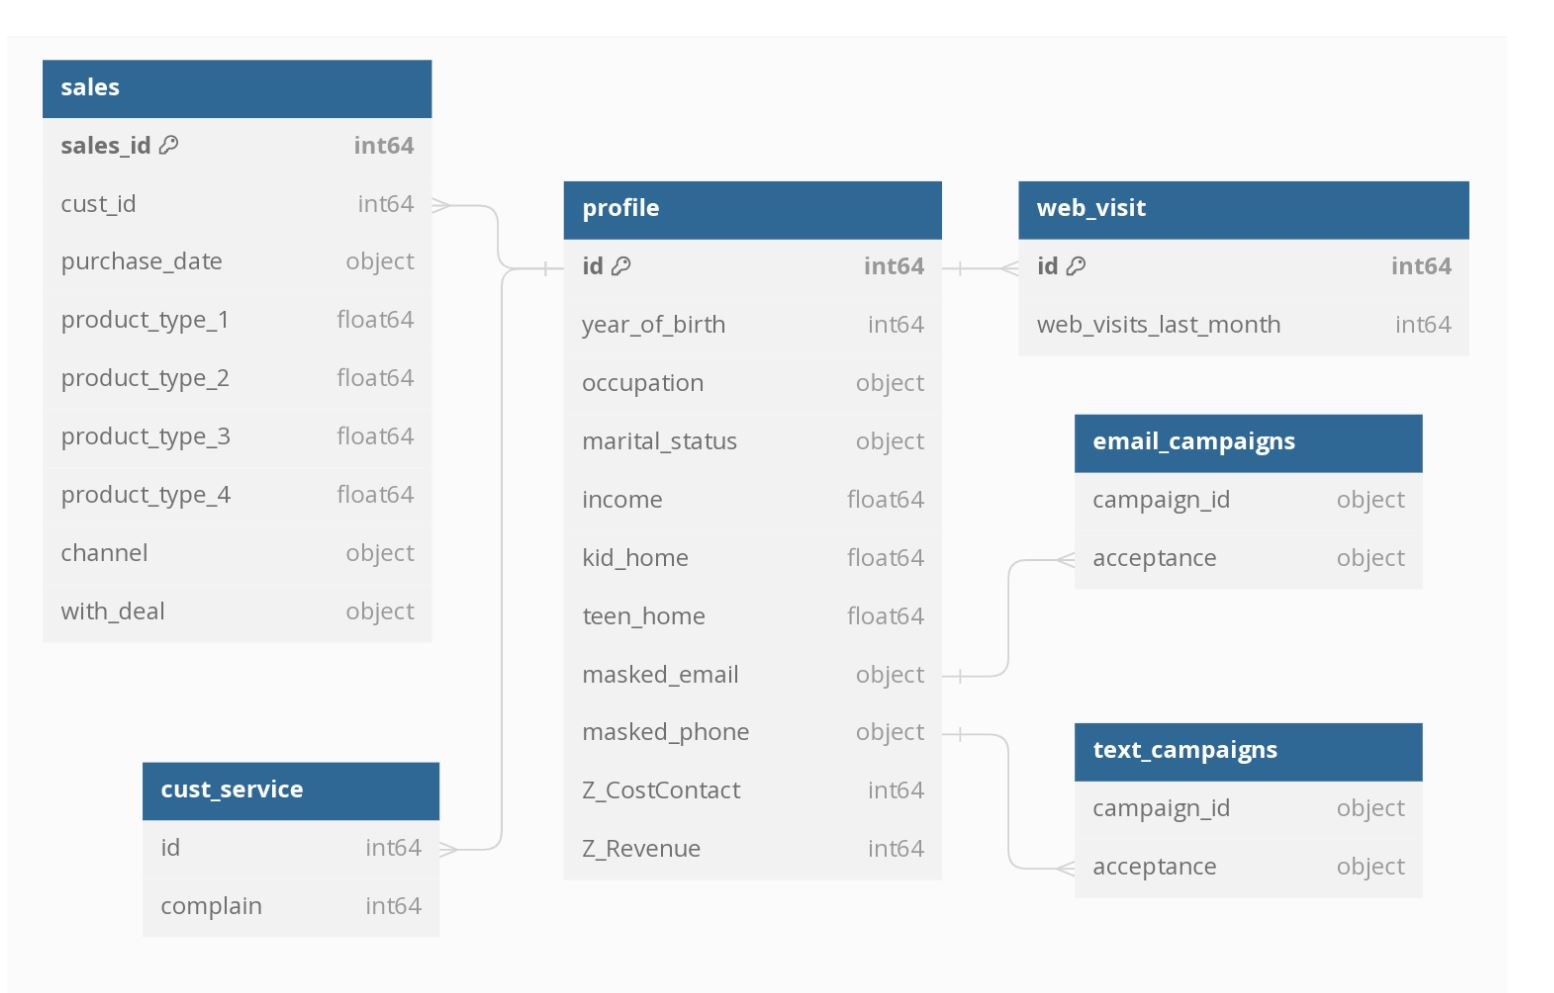

In [49]:
img = Image.open('dataschema.JPG')
display(img)

In [50]:
# loading Data

df_profile = pd.read_excel("cust_seg_data.xlsx", sheet_name = "profile").drop_duplicates()
df_sales = pd.read_excel("cust_seg_data.xlsx", sheet_name = "sales").drop_duplicates()
df_email_campaigns = pd.read_excel("cust_seg_data.xlsx", sheet_name = "email_campaigns").drop_duplicates()
df_text_campaigns = pd.read_excel("cust_seg_data.xlsx", sheet_name = "text_campaigns").drop_duplicates()
df_cust_service = pd.read_excel("cust_seg_data.xlsx", sheet_name = "cust_service").drop_duplicates()
df_web_visit = pd.read_excel("cust_seg_data.xlsx", sheet_name = "web_visit").drop_duplicates()



In [10]:
df_profile.info()
df_profile.describe(include = 'all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2237 non-null   int64  
 1   year_of_birth   2237 non-null   int64  
 2   occupation      2019 non-null   object 
 3   marital_status  2031 non-null   object 
 4   income          2213 non-null   float64
 5   kid_home        2011 non-null   float64
 6   teen_home       2011 non-null   float64
 7   masked_email    1794 non-null   object 
 8   masked_phone    1774 non-null   object 
 9   Z_CostContact   2237 non-null   int64  
 10  Z_Revenue       2237 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 192.4+ KB


id  year_of_birth        occupation marital_status  \
count     2237.000000    2237.000000              2019           2031   
unique            NaN            NaN                 3              8   
top               NaN            NaN  skilled employee        Married   
freq              NaN            NaN              1522            787   
mean    101120.153777    1974.584712               NaN            NaN   
std        647.020367      37.586699               NaN            NaN   
min     100001.000000    1000.000000               NaN            NaN   
25%     100560.000000    1966.000000               NaN            NaN   
50%     101120.000000    1977.000000               NaN            NaN   
75%     101680.000000    1984.000000               NaN            NaN   
max     102240.000000    2003.000000               NaN            NaN   

               income     kid_home    teen_home         masked_email  \
count     2213.000000  2011.000000  2011.000000                 1794   
unique            NaN          NaN          NaN                 1794   
top               NaN          NaN          NaN  xxxxx2240@email.com   
freq              NaN          NaN          NaN                    1   
mean     52311.851785     0.439582     0.508205                  NaN   
std      25128.669274     0.536902     0.544815                  NaN   
min       2447.000000     0.000000     0.000000                  NaN   
25%      35388.000000     0.000000     0.000000                  NaN   
50%      51411.000000     0.000000     0.000000                  NaN   
75%      68627.000000     1.000000     1.000000                  NaN   
max     666666.000000     2.000000     2.000000                  NaN   

           masked_phone  Z_CostContact  Z_Revenue  
count              1774         2237.0     2237.0  
unique             1774            NaN        NaN  
top     xxx-xxx-xxx2240            NaN        NaN  
freq                  1            NaN        NaN  
mean                NaN            3.0       11.0  
std                 NaN            0.0        0.0  
min                 NaN            3.0       11.0  
25%                 NaN            3.0       11.0  
50%                 NaN            3.0       11.0  
75%                 NaN            3.0       11.0  
max                 NaN            3.0       11.0

In [11]:
print("Total categories in the feature marital_status:\n", df_profile["marital_status"].value_counts(),"\n")
print("Total categories in the feature occupation:\n", df_profile["occupation"].value_counts(),"\n")

Total categories in the feature marital_status:
 marital_status
Married     787
Together    527
Single      438
Divorced    202
Widow        71
Alone         2
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature occupation:
 occupation
skilled employee              1522
management / self-employed     446
unemployed                      51
Name: count, dtype: int64 



In [12]:
df_sales.info()
df_sales.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28086 entries, 0 to 28085
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales_id        28086 non-null  int64  
 1   cust_id         28086 non-null  int64  
 2   purchase_date   28086 non-null  object 
 3   product_type_1  27642 non-null  float64
 4   product_type_2  27978 non-null  float64
 5   product_type_3  24354 non-null  float64
 6   product_type_4  25535 non-null  float64
 7   channel         28086 non-null  object 
 8   with_deal       28086 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.9+ MB


sales_id        cust_id        purchase_date  product_type_1  \
count   28086.000000   28086.000000                28086     27642.00000   
unique           NaN            NaN                  990             NaN   
top              NaN            NaN  2020-09-25 00:00:00             NaN   
freq             NaN            NaN                   91             NaN   
mean    14043.500000  101122.682048                  NaN        24.62680   
std      8107.874167     644.781098                  NaN        51.29299   
min         1.000000  100001.000000                  NaN         1.00000   
25%      7022.250000  100565.000000                  NaN         2.00000   
50%     14043.500000  101117.000000                  NaN         6.00000   
75%     21064.750000  101687.000000                  NaN        21.00000   
max     28086.000000  102240.000000                  NaN       717.00000   

        product_type_2  product_type_3  product_type_4 channel with_deal  
count     27978.000000    24354.000000    25535.000000   28086     28086  
unique             NaN             NaN             NaN       2         2  
top                NaN             NaN             NaN     Web        no  
freq               NaN             NaN             NaN   15113     22922  
mean         16.370076        4.906915        3.863677     NaN       NaN  
std          38.717140        9.913493        7.238673     NaN       NaN  
min           1.000000        1.000000        1.000000     NaN       NaN  
25%           2.000000        1.000000        1.000000     NaN       NaN  
50%           4.000000        2.000000        1.000000     NaN       NaN  
75%          12.000000        4.000000        3.000000     NaN       NaN  
max        1619.000000      155.000000      229.000000     NaN       NaN

# 3.Data Cleaning & Feature Engineerning

## 3.1 Data Cleaning

###3.1.1 Categorical feature standardization

In [13]:
# Deriving living situation by marital status
df_profile["living_with"]=df_profile["marital_status"].replace({
    "Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone",
    "Single":"Alone", "Divorced":"Alone", "Alone":"Alone","YOLO":"Alone",
})

print("Total categories in the feature living_with :\n", df_profile["living_with"].value_counts(), "\n")

Total categories in the feature living_with :
 living_with
Partner    1314
Alone       717
Name: count, dtype: int64 



###3.1.2 Illegal value : Remove rows

In [14]:
print("Oldest customer's year_of_birth in df_profile:", min(df_profile['year_of_birth']))
print("Number of profile records with year_of_birth outrange:", len(df_profile[df_profile['year_of_birth']<1900]))

#print("Max customer's purchase date in df_sales:", max(df_sales['purchase_date']))
print("Number of sales records with date outrange:", len(df_sales[df_sales['purchase_date']>datetime.datetime(2024,1,1)]))

print("Number of sales records with 0 in all 4 product types:",
      len(df_sales[df_sales[['product_type_1', 'product_type_2', 'product_type_3', 'product_type_4']].isnull().all(1)]))

Oldest customer's year_of_birth in df_profile: 1000
Number of profile records with year_of_birth outrange: 3
Number of sales records with date outrange: 2
Number of sales records with 0 in all 4 product types: 2


In [15]:
# Drop
df_profile = df_profile[df_profile['year_of_birth']>1900]
df_sales = df_sales[df_sales['purchase_date']<datetime.datetime(2024,1,1)]
df_sales = df_sales[~df_sales[['product_type_1', 'product_type_2', 'product_type_3', 'product_type_4']].isnull().all(1)]

print("df_profile : total number of data after removing the rows with missing value are:", len(df_profile))
print("df_sales: total number of data after removing the rows with missing values are:", len(df_sales))

df_profile : total number of data after removing the rows with missing value are: 2234
df_sales: total number of data after removing the rows with missing values are: 28082


###3.1.3 Null value :

In [16]:
# To remove the NA values
df_profile = df_profile.dropna(axis=0, subset=['income'])
print("The total number of data-points after removing the rows with missing values are:", len(df_profile))

The total number of data-points after removing the rows with missing values are: 2210


In [17]:
# Fill using most common values
df_profile [['occupation']] = df_profile[['occupation']].fillna(value='skilled employee')
df_profile [['living_with']] = df_profile[['living_with']].fillna(value='Partner')

# Fill wiht 0
df_profile[['kid_home', 'teen_home']] = df_profile[['kid_home', 'teen_home']].fillna(value=0)

# Drop irrelevant columns
df_profile = df_profile.drop(columns=['Z_CostContact', 'Z_Revenue'])

df_profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2210 entries, 0 to 2236
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2210 non-null   int64  
 1   year_of_birth   2210 non-null   int64  
 2   occupation      2210 non-null   object 
 3   marital_status  2005 non-null   object 
 4   income          2210 non-null   float64
 5   kid_home        2210 non-null   float64
 6   teen_home       2210 non-null   float64
 7   masked_email    1773 non-null   object 
 8   masked_phone    1750 non-null   object 
 9   living_with     2210 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 189.9+ KB


## 3.2 Feature Engineering

### 3.2.1 Aggregation

Aggregating Sales Data for Customer-Level Features

In [18]:
# Aggregate
df_sales["with_deal_code"]=df_sales["with_deal"].replace({"no":0, "yes":1})
df_sales_agg = df_sales.groupby('cust_id').agg({
    'purchase_date': ['min', 'max'],
    'product_type_1' : 'sum',
    'product_type_2' : 'sum',
    'product_type_3' : 'sum',
    'product_type_4' : 'sum',
    'with_deal_code' : 'sum',
})

df_sales_agg.columns = df_sales_agg.columns.map('_'.join)
df_sales_agg = df_sales_agg.reset_index()

#Aggregate(special): for channel we need to split count web/store
gb = df_sales.groupby(['cust_id', 'channel']).size().unstack(fill_value = 0).reset_index()
df_sales_agg = df_sales_agg.merge(gb, on='cust_id', how='left')
df_sales_agg = df_sales_agg.rename({
    'purchase_date_min':'cust_enrollment_dt',
    'purchase_date_max':'recency',
    'product_type_1_sum':'prodtype_1_amt',
    'product_type_2_sum':'prodtype_2_amt',
    'product_type_3_sum':'prodtype_3_amt',
    'product_type_4_sum':'prodtype_4_amt',
    'with_deal_code_sum':'purchase_num_with_deal',
    'Web': 'purchase_num_web',
    'Store': 'purchase_num_store',
    }, axis = 1)
df_sales_agg.head()

cust_id   cust_enrollment_dt              recency  prodtype_1_amt  \
0   100001  2018-04-14 00:00:00  2020-11-04 00:00:00           635.0   
1   100002  2020-08-08 00:00:00  2020-11-24 00:00:00            11.0   
2   100003  2019-08-26 00:00:00  2020-12-06 00:00:00           426.0   
3   100004  2020-10-07 00:00:00  2020-12-06 00:00:00            11.0   
4   100005  2020-01-24 00:00:00  2020-09-29 00:00:00           173.0   

   prodtype_2_amt  prodtype_3_amt  prodtype_4_amt  purchase_num_with_deal  \
0           718.0           176.0            88.0                       3   
1             8.0             2.0             6.0                       2   
2           238.0            70.0            42.0                       1   
3            30.0             7.0             5.0                       2   
4           164.0            70.0            15.0                       5   

   purchase_num_store  purchase_num_web  
0                   4                18  
1                   2                 2  
2                  10                10  
3                   4                 2  
4                   6                 8

### 3.2.2 Pivot table

Use pivot_table from pandas to transform the data into features for the model

In [19]:
df_email_cmpgns_pivot = df_email_campaigns\
    .pivot_table(values='acceptance', index='acceptance', columns='campaign_id', aggfunc=lambda x: len(x))\
    .reset_index()
df_text_cmpgns_pivot = df_text_campaigns\
    .pivot_table(values='acceptance', index='acceptance', columns='campaign_id', aggfunc=lambda x: len(x))\
    .reset_index()
df_email_cmpgns_pivot.head()

campaign_id           acceptance  email_campaign_1  email_campaign_2  \
0            xxxxx1001@email.com               NaN               1.0   
1            xxxxx1002@email.com               NaN               NaN   
2            xxxxx1003@email.com               1.0               NaN   
3            xxxxx1006@email.com               1.0               NaN   
4            xxxxx1008@email.com               NaN               NaN   

campaign_id  email_campaign_3  email_campaign_4  
0                         1.0               NaN  
1                         1.0               1.0  
2                         NaN               1.0  
3                         NaN               NaN  
4                         1.0               NaN

### 3.2.3 Merge

Combines the Profile with the aggregated sales data, as well as the pivoted email campaign, text campaign, customer serivce (cust_service) and web visit tables, in order to obtain a final unified dataset.



In [20]:
data = df_profile.merge(df_sales_agg,left_on='id',right_on='cust_id', how='left')\
    .merge(df_email_cmpgns_pivot,left_on='masked_email',right_on='acceptance', how='left')\
    .merge(df_text_cmpgns_pivot,left_on='masked_phone',right_on='acceptance', how='left')\
    .merge(df_cust_service, on='id', how='left')\
    .merge(df_web_visit, on='id', how='left').fillna(0)

# create features:
data.columns

Index(['id', 'year_of_birth', 'occupation', 'marital_status', 'income',
       'kid_home', 'teen_home', 'masked_email', 'masked_phone', 'living_with',
       'cust_id', 'cust_enrollment_dt', 'recency', 'prodtype_1_amt',
       'prodtype_2_amt', 'prodtype_3_amt', 'prodtype_4_amt',
       'purchase_num_with_deal', 'purchase_num_store', 'purchase_num_web',
       'acceptance_x', 'email_campaign_1', 'email_campaign_2',
       'email_campaign_3', 'email_campaign_4', 'acceptance_y',
       'text_campaign_1', 'text_campaign_2', 'complain',
       'web_visits_last_month'],
      dtype='object')

### 3.2.4 Transformation

Some data needs to be transformed. For example, dates labeled should be converted into durations, and birth dates should be transformed into age

In [21]:
# timestamp -> duration
d1 = max(df_sales['purchase_date'])
data["enrollment_days"] = data["cust_enrollment_dt"].apply(lambda x: pd.Timestamp(d1) - pd.Timestamp(x))
data["enrollment_days"] = data["enrollment_days"].dt.days
data["recency_days"] = data["recency"].apply(lambda x: pd.Timestamp(d1) - pd.Timestamp(x))
data["recency_days"] = data["recency_days"].dt.days

# year_of_birth -> age
data["age"] = 2021-data["year_of_birth"]

# total spendings on various items
data["spent"] = data["prodtype_1_amt"]+data["prodtype_2_amt"]+data["prodtype_3_amt"]+data["prodtype_4_amt"]

# total purchase number
data["purchase_num"] = data["purchase_num_store"]+data["purchase_num_web"]

# total campaigns accepted
data["campaigns_accepted"] = data['email_campaign_1']+data['email_campaign_2']+data['email_campaign_3']\
  +data['email_campaign_4']+data['text_campaign_1']+data['text_campaign_2']

# total children
data["children"]=data["kid_home"]+data["teen_home"]

# total members in the householde
data["family_size"] = data["living_with"].replace({"Alone": 1, "Partner":2})+ data["children"]

#Dropping some of the redundant features
to_drop = ['id','year_of_birth','marital_status','masked_email', 'masked_phone','cust_id',
    'email_campaign_1', 'email_campaign_2','email_campaign_3', 'email_campaign_4',
    'text_campaign_1', 'text_campaign_2',
    'cust_enrollment_dt', 'acceptance_x','acceptance_y','recency'
]
data = data.drop(to_drop, axis=1)

# 4.Exploratory Data Analysis (EDA)

Involves cleaning the data, describing it (using descriptive statistics and visualizations), examining distributions, exploring relationships between variables, developing an intuition for the data, and summarizing key insights.    


In the previous section, we performed data cleaning and feature engineering. Next, we’ll take a closer look at the overall picture of the data.

## 4.1 Data Overview after cleaning

In [22]:
data.describe(include = 'all')

occupation         income     kid_home    teen_home living_with  \
count               2210    2210.000000  2210.000000  2210.000000        2210   
unique                 3            NaN          NaN          NaN           2   
top     skilled employee            NaN          NaN          NaN     Partner   
freq                1719            NaN          NaN          NaN        1505   
mean                 NaN   52301.255204     0.393213     0.456109         NaN   
std                  NaN   25134.179988     0.524328     0.538362         NaN   
min                  NaN    2447.000000     0.000000     0.000000         NaN   
25%                  NaN   35352.000000     0.000000     0.000000         NaN   
50%                  NaN   51400.500000     0.000000     0.000000         NaN   
75%                  NaN   68592.000000     1.000000     1.000000         NaN   
max                  NaN  666666.000000     2.000000     2.000000         NaN   

        prodtype_1_amt  prodtype_2_amt  prodtype_3_amt  prodtype_4_amt  \
count      2210.000000     2210.000000     2210.000000     2210.000000   
unique             NaN             NaN             NaN             NaN   
top                NaN             NaN             NaN             NaN   
freq               NaN             NaN             NaN             NaN   
mean        305.528959      204.836199       53.413575       43.967421   
std         337.378475      259.611449       71.676692       51.712527   
min           0.000000        0.000000        0.000000        0.000000   
25%          24.000000       22.000000        5.000000        9.000000   
50%         176.000000       80.500000       19.000000       25.000000   
75%         505.000000      308.000000       76.000000       56.000000   
max        1493.000000     1727.000000      378.000000      321.000000   

        purchase_num_with_deal  purchase_num_store  purchase_num_web  \
count              2210.000000         2210.000000       2210.000000   
unique                     NaN                 NaN               NaN   
top                        NaN                 NaN               NaN   
freq                       NaN                 NaN               NaN   
mean                  2.308145            5.813122          6.767873   
std                   1.868123            3.245906          4.718414   
min                   0.000000            0.000000          0.000000   
25%                   1.000000            3.000000          2.000000   
50%                   2.000000            5.000000          6.000000   
75%                   3.000000            8.000000         10.000000   
max                  15.000000           13.000000         28.000000   

          complain  web_visits_last_month  enrollment_days  recency_days  \
count   2210.00000            2210.000000      2210.000000   2210.000000   
unique         NaN                    NaN              NaN           NaN   
top            NaN                    NaN              NaN           NaN   
freq           NaN                    NaN              NaN           NaN   
mean       0.00905               5.313575       567.529412     83.281900   
std        0.09472               2.430724       803.380978    790.756514   
min        0.00000               0.000000        22.000000      0.000000   
25%        0.00000               3.000000       363.000000     24.000000   
50%        0.00000               6.000000       535.000000     49.000000   
75%        0.00000               7.000000       710.000000     74.000000   
max        1.00000              20.000000     18628.000000  18628.000000   

                age        spent  purchase_num  campaigns_accepted  \
count   2210.000000  2210.000000   2210.000000         2210.000000   
unique          NaN          NaN           NaN                 NaN   
top             NaN          NaN           NaN                 NaN   
freq            NaN          NaN           NaN                 NaN   
mean      45.090950   60

## 4.2 Data Visualization

We need to compare the relationships between these columns by performing pairwise comparisons. This will help us identify the relationships between the data and detect outliers. For example, in the "income" row, there's a distinct point in the upper-left corner, or in the "recency" column, there are individual points on the far right.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

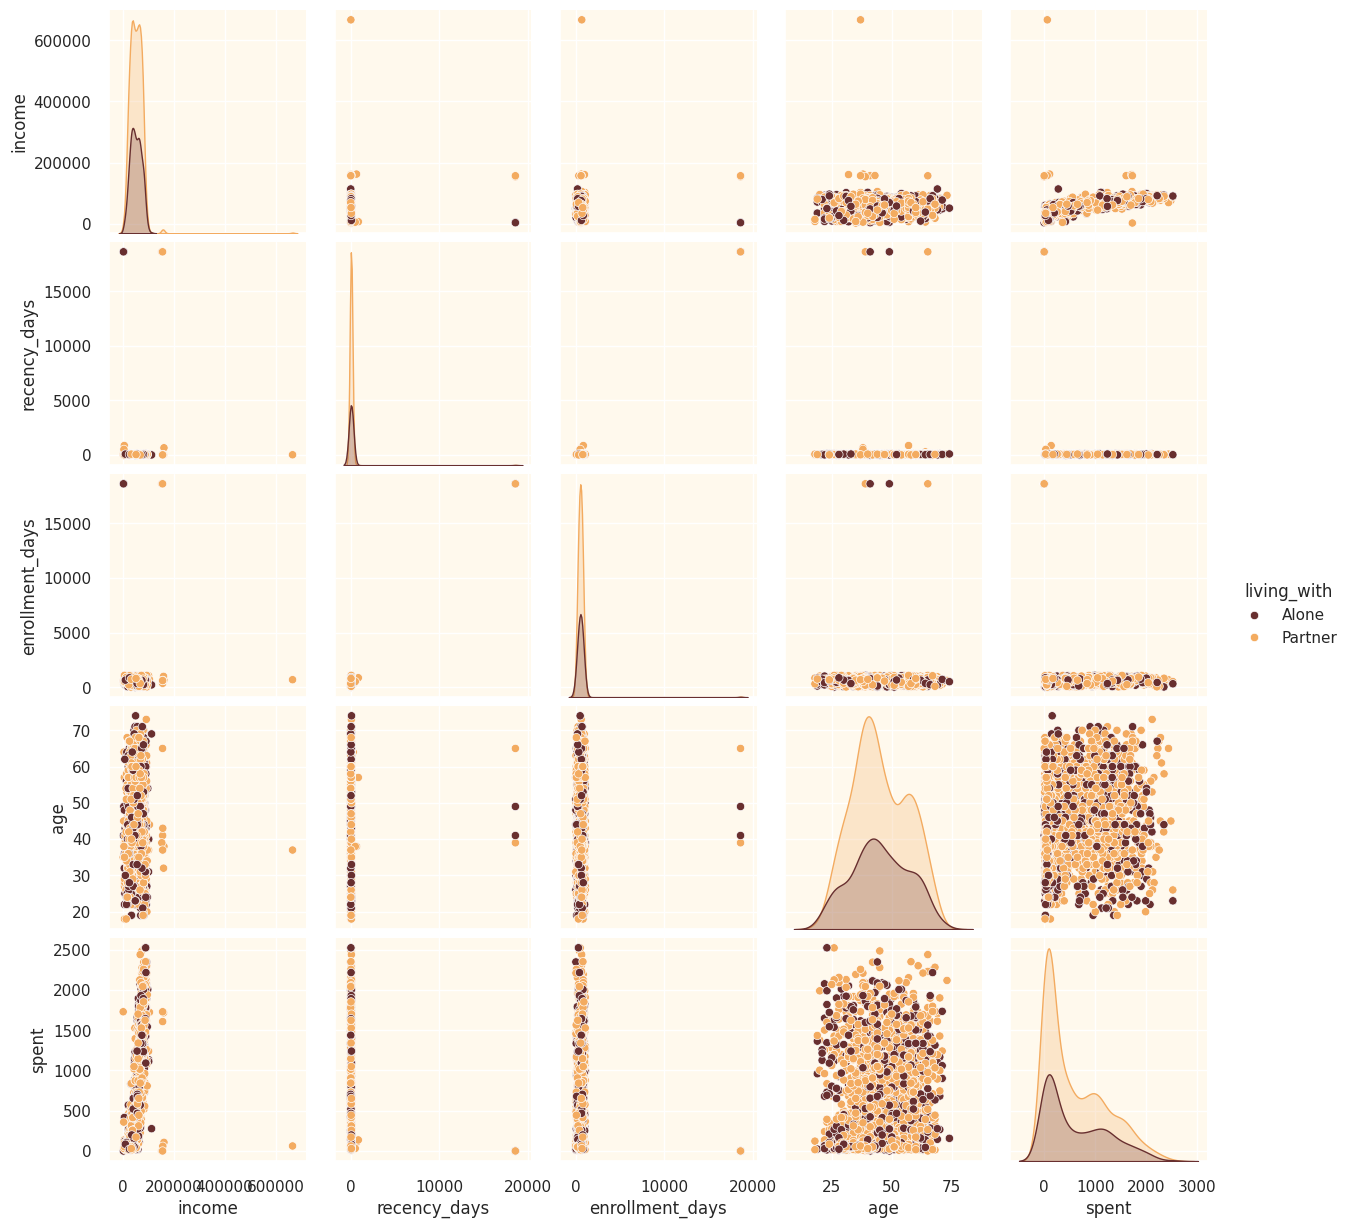

In [23]:
sns.set(rc={"axes.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

To_Plot = ["income", "recency_days", "enrollment_days", "age", "spent", "living_with"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "living_with",palette= (["#682F2F","#F3AB60"]))
plt.show()

The total number of data-points after removing the outliers are: 1773


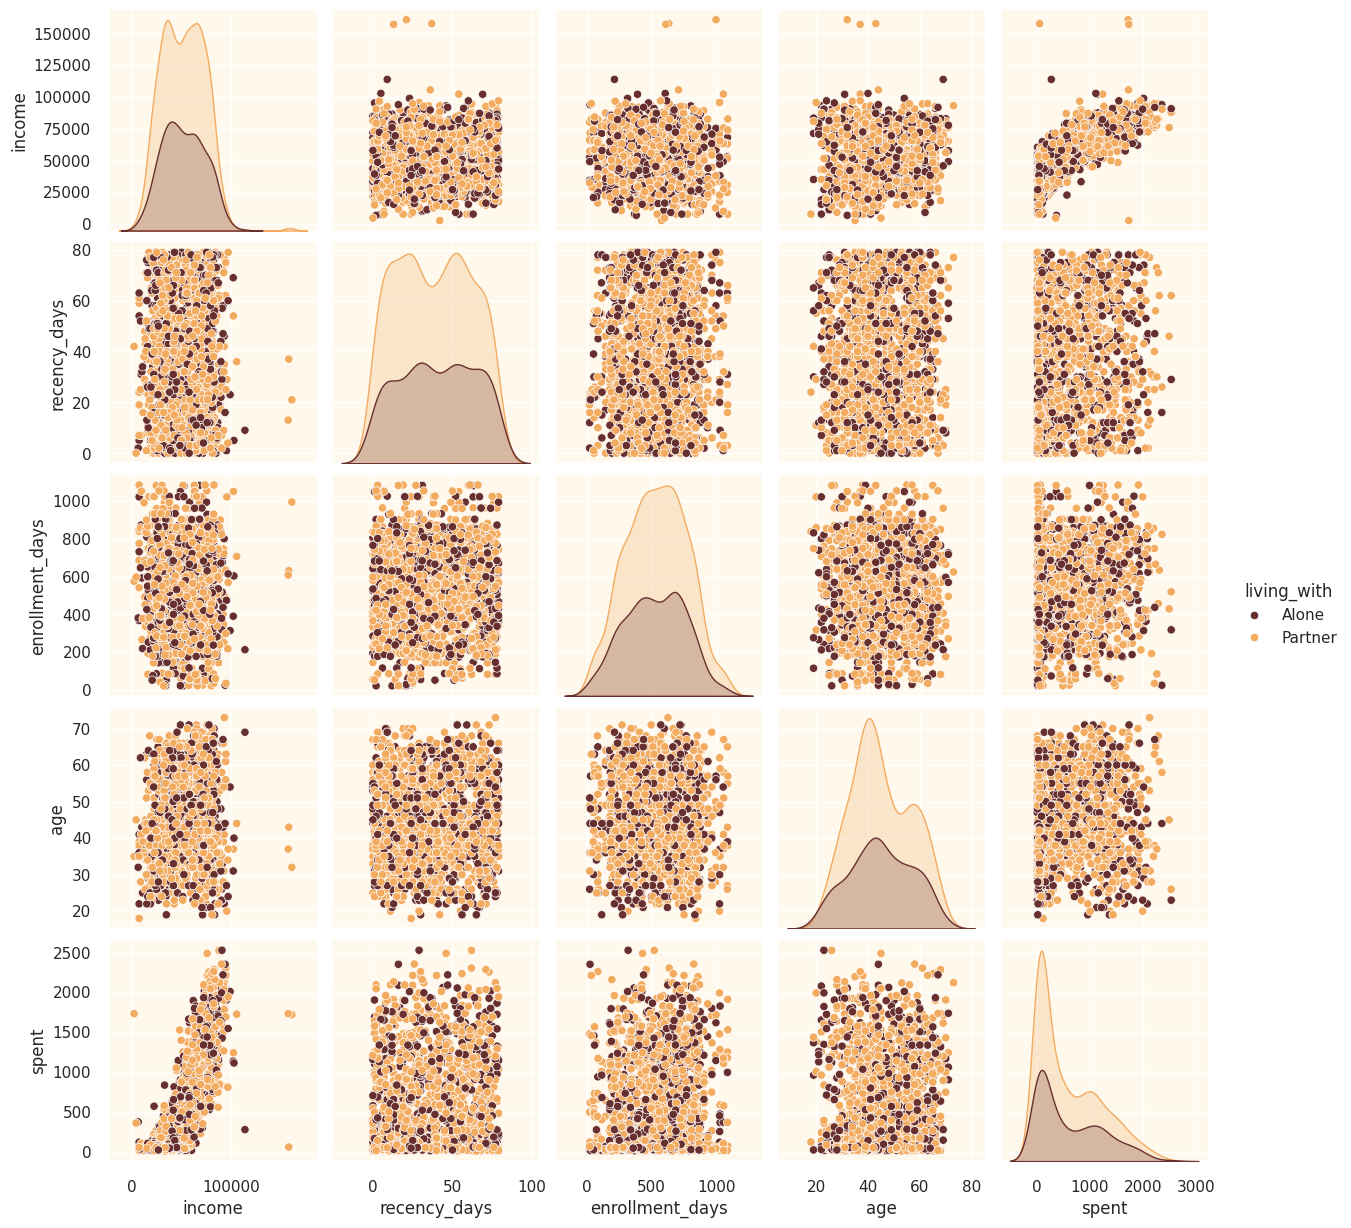

In [24]:
# remove the outliers and then display the data again.
data = data[(data["income"]<500000)]
data = data[(data["recency_days"]<80)]
print("The total number of data-points after removing the outliers are:", len(data))
sns.pairplot(data[To_Plot], hue= "living_with",palette= (["#682F2F","#F3AB60"]))
plt.show()

In the above chart, we can observe the relationship between income and the other columns. We can see that there is a positive correlation between income and spent.

## 4.3 Correlation matrix

<Axes: >

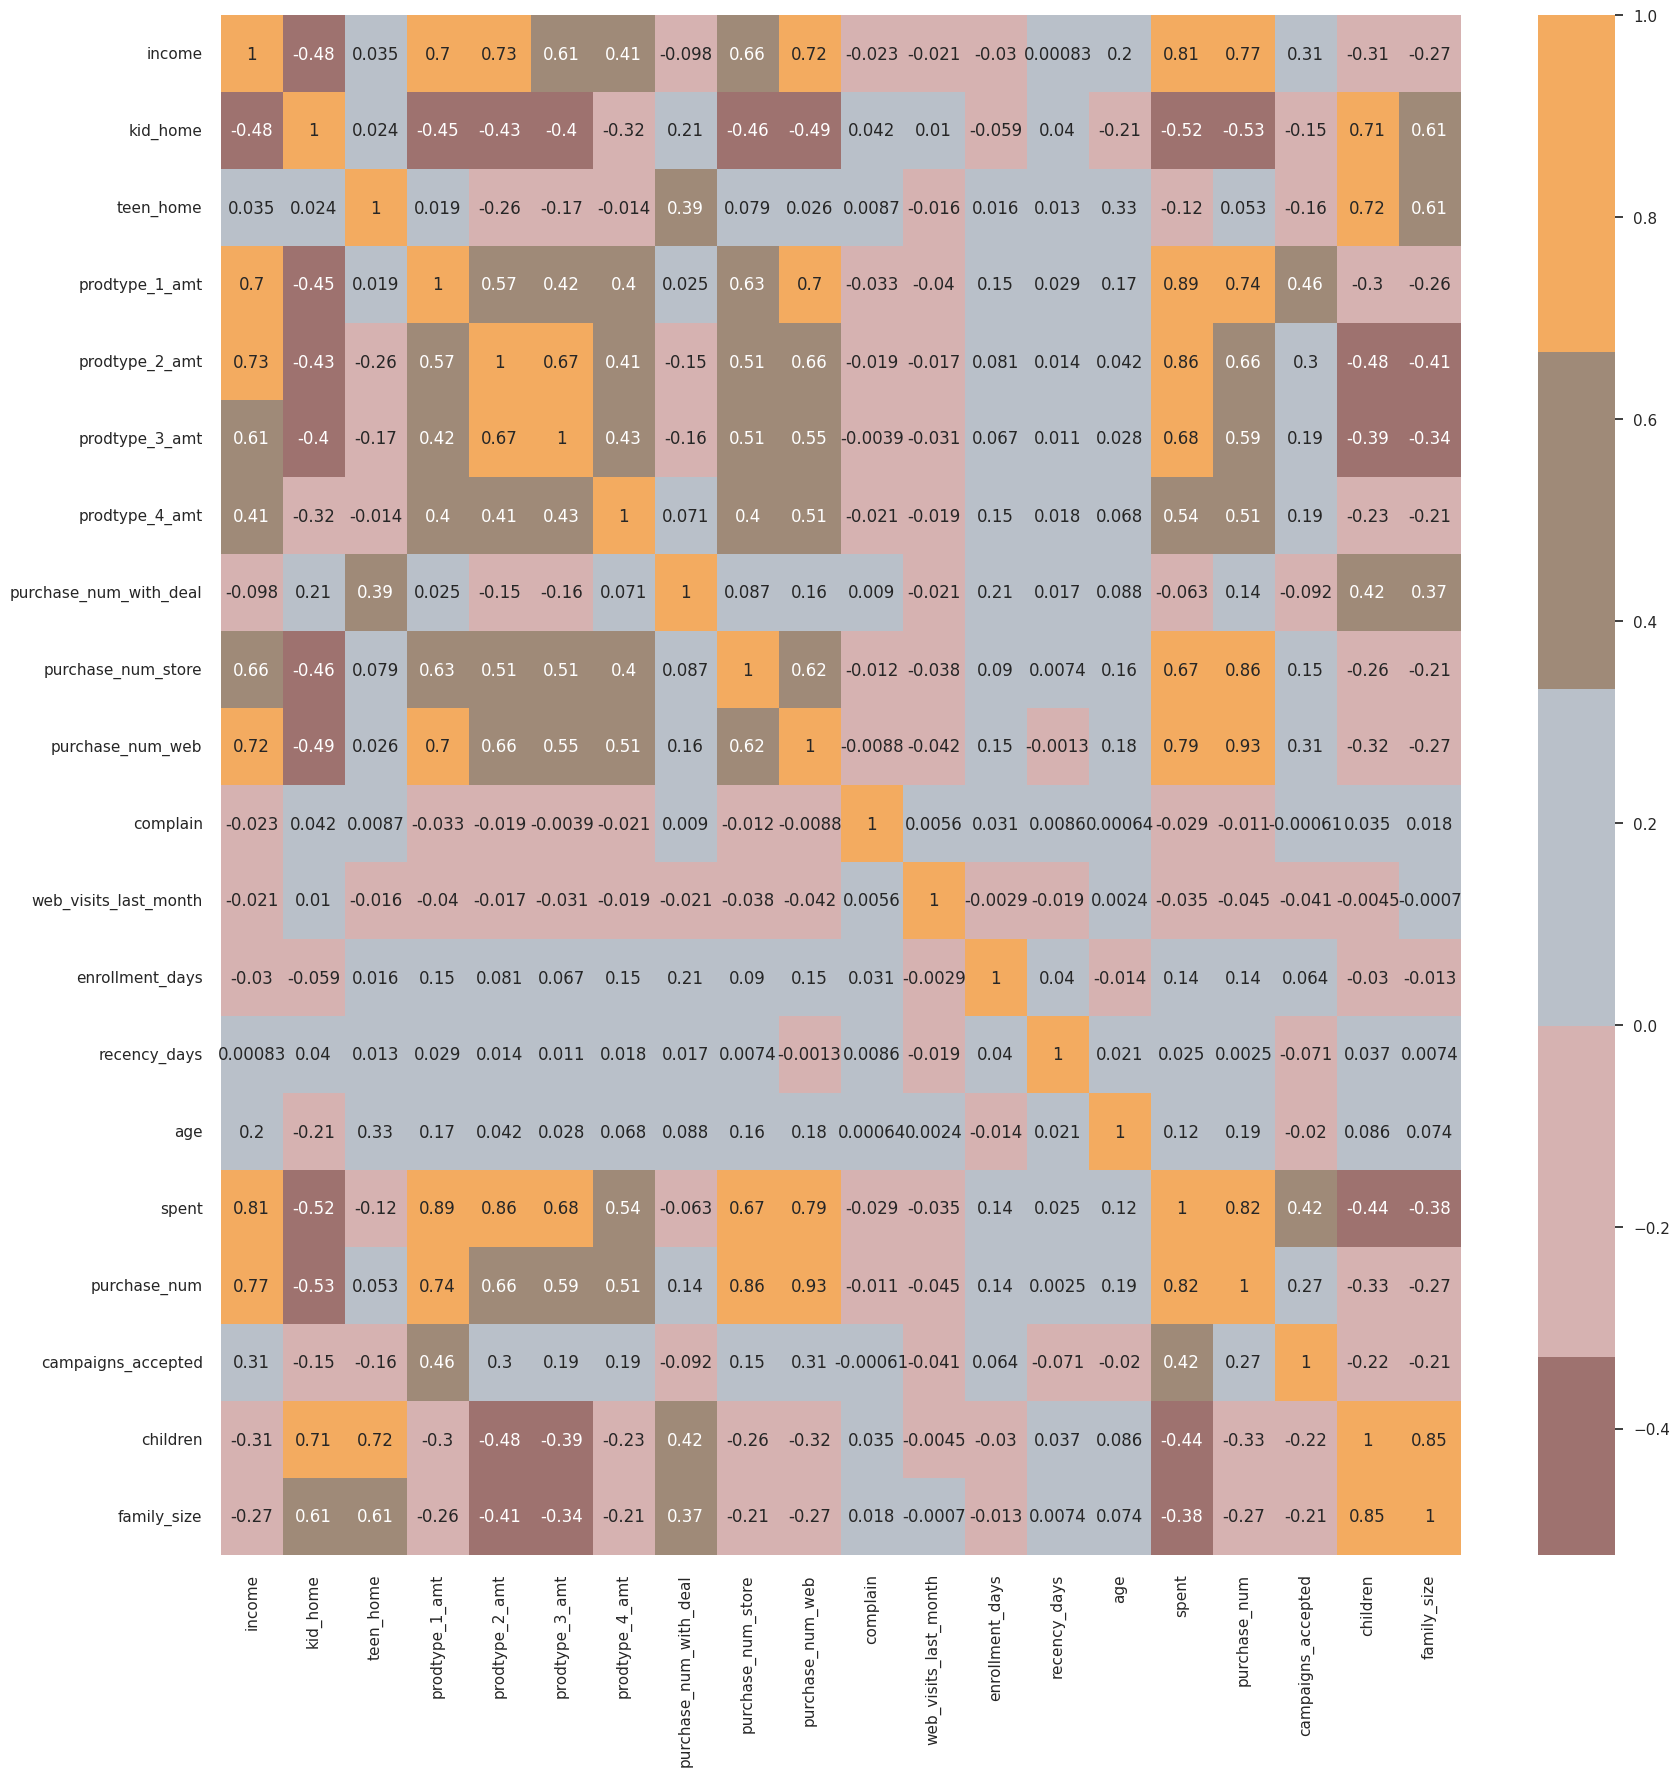

In [25]:
#correlation matrix
numeric_data = data.select_dtypes(include=['number'])
corrmat= numeric_data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

- Data Insight:
From the visualization, we observe a significant relationship between **income** and **product types 1 and 2**, as well as between **spending** and **purchase frequency**. This is expected, as individuals with higher income tend to have higher spending and a greater number of purchases.

# 5.Data Preprocess

## 5.1 Label encoding the categorical features

- **Encoding** it is a preprocessing technique used for encoding categorical data into numerical format. It's used when you have categorical labels or classes
- **LabelEncoder** assigns a unique integer to each category in a categorical feature, effectively converting categorical data into ordinal data. LabelEncoder

In [26]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables in the dataset:", object_cols)

#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
print("All features are now numerical")
data.head()

Categorical variables in the dataset: ['occupation', 'living_with']
All features are now numerical


occupation   income  kid_home  teen_home  living_with  prodtype_1_amt  \
0           1  58138.0       0.0        0.0            0           635.0   
1           1  46344.0       1.0        1.0            0            11.0   
2           1  71613.0       0.0        0.0            1           426.0   
3           1  26646.0       1.0        0.0            1            11.0   
5           1  62513.0       0.0        1.0            1           520.0   

   prodtype_2_amt  prodtype_3_amt  prodtype_4_amt  purchase_num_with_deal  \
0           718.0           176.0            88.0                     3.0   
1             8.0             2.0             6.0                     2.0   
2           238.0            70.0            42.0                     1.0   
3            30.0             7.0             5.0                     2.0   
5            98.0            84.0            14.0                     2.0   

   purchase_num_store  purchase_num_web  complain  web_visits_last_month  \
0                 4.0              18.0       0.0                      9   
1                 2.0               2.0       0.0                      6   
2                10.0              10.0       0.0                      6   
3                 4.0               2.0       0.0                      7   
5                10.0              10.0       0.0                      6   

   enrollment_days  recency_days  age   spent  purchase_num  \
0              993            58   57  1617.0          22.0   
1              146            38   60    27.0           4.0   
2              494            26   49   776.0          20.0   
3               86            26   30    53.0           6.0   
5              475            16   47   716.0          20.0   

   campaigns_accepted  children  family_size  
0                 1.0       0.0          1.0  
1                 0.0       2.0          3.0  
2                 0.0       0.0          2.0  
3                 0.0       1.0          3.0  
5                 0.0       1.0          3.0

## 5.2 Scaling the features using the standard scaler

- **Scaling** is a data preprocessing technique used to transform numerical features in a dataset to a common range or scale, typically within the range of 0 to 1 or -1 to 1.
- **Scaling** is important because many machine learning algorithms are sensitive to the magnitude of features. By scaling features, you ensure that no single feature dominates the others, leading to more stable and accurate model performance. Algorithms such as k-Nearest Neighbors (KNN) and Support Vector Machines (SVM) are particularly sensitive to feature scaling.

In [27]:
#Creating a copy of data
ds = data.copy()
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [28]:
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


occupation    income  kid_home  teen_home  living_with  prodtype_1_amt  \
0    0.403009  0.293472 -0.755294  -0.847108    -1.425051        0.971419   
1    0.403009 -0.267901  1.155029   1.030295    -1.425051       -0.872825   
2    0.403009  0.934858 -0.755294  -0.847108     0.701729        0.353716   
3    0.403009 -1.205491  1.155029  -0.847108     0.701729       -0.872825   
4    0.403009  0.501714 -0.755294   1.030295     0.701729        0.631534   

   prodtype_2_amt  prodtype_3_amt  prodtype_4_amt  purchase_num_with_deal  \
0        1.997827        1.700331        0.865803                0.359162   
1       -0.762884       -0.715439       -0.743263               -0.170617   
2        0.131431        0.228655       -0.036844               -0.700397   
3       -0.677341       -0.646021       -0.762886               -0.170617   
4       -0.412934        0.423027       -0.586281               -0.170617   

   purchase_num_store  purchase_num_web  complain  web_visits_last_month  \
0           -0.566937          2.414301 -0.095428               1.518694   
1           -1.182478         -1.016662 -0.095428               0.288802   
2            1.279687          0.698819 -0.095428               0.288802   
3           -0.566937         -1.016662 -0.095428               0.698766   
4            1.279687          0.698819 -0.095428               0.288802   

   enrollment_days  recency_days       age     spent  purchase_num  \
0         1.997051      0.824445  1.012752  1.682034      1.316508   
1        -1.659754     -0.039698  1.266907 -0.968354     -1.199965   
2        -0.157312     -0.558184  0.335004  0.280162      1.036900   
3        -1.918796     -0.558184 -1.274648 -0.925014     -0.920357   
4        -0.239342     -0.990255  0.165567  0.180148      1.036900   

   campaigns_accepted  children  family_size  
0            0.775822 -1.120412    -1.690679  
1           -0.475800  1.526477     0.538829  
2           -0.475800 -1.120412    -0.575925  
3           -0.475800  0.203033     0.538829  
4           -0.475800  0.203033     0.538829

# 6.Dimensionality Reduction


##6.1 Why need to dimensiona reduction
- Eliminates noisy data dimensions : and thus improves accuracy in clustering, and enhance the generalization ability of the model
- The curse of dimensionality : Clustering generally depends on some sort of distance measure. Points near each other are in the same cluster; points far apart are in different clusters. But in high dimensional spaces, distance measures do not work very well.

##6.2 Number of Dimensions

- Cumulative sum of eigenvalues
  - The cumulative sum of eigenvalues in PCA represents the total proportion of variance explained by the selected principal components in a dataset. It quantifies how much of the original data's variability is captured as more principal components are included in the analysis.
  - Analyzing the cumulative sum of eigenvalues is essential in PCA to make informed decisions about how many principal components to retain.

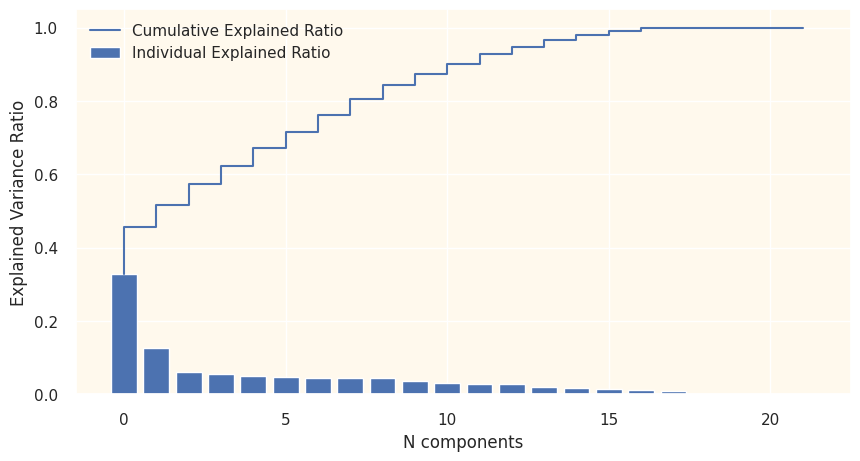

In [29]:
pca = PCA()
pca.fit(scaled_ds)
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Individual Explained Ratio")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label="Cumulative Explained Ratio")
plt.xlabel("N components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc="best")
plt.show()

##6.3 PCA

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

In [30]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  1773.0  1.282423e-16  2.688052 -4.781418 -2.478521 -0.478731  2.380668   
col2  1773.0 -4.809088e-17  1.671733 -3.795233 -1.253080 -0.297675  1.227802   
col3  1773.0 -4.408331e-17  1.158286 -3.475447 -0.750119  0.030082  0.764711   

           max  
col1  7.322954  
col2  6.771321  
col3  4.141235

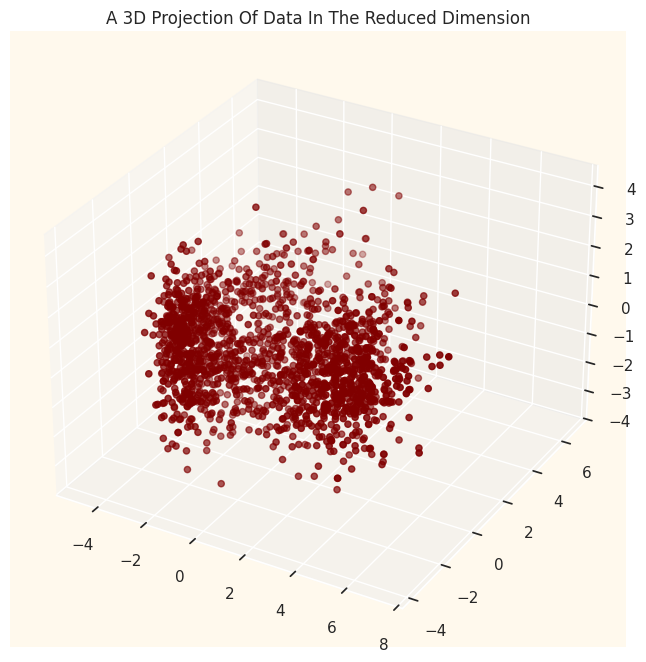

In [31]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

#7.Model Training
Common clustering algorithms:

- K-Means Clustering: Divides the dataset into K clusters, where each cluster is centered around its centroid, and the data points within each cluster have a smaller distance to the centroid.

- Hierarchical Clustering: Organizes data through a hierarchical tree (dendrogram), which can be either agglomerative (bottom-up) or divisive (top-down).

- DBSCAN (Density-Based Spatial Clustering of Applications with Noise): Divides the data into clusters based on the density of data points, forming clusters in high-density regions and treating low-density regions as noise.

- Agglomerative Clustering: Starts with each data point as its own cluster and progressively merges similar data points, forming a hierarchical structure of clusters.

- Gaussian Mixture Model (GMM): Assumes that data points are generated from a mixture of several Gaussian distributions, and it uses maximum likelihood estimation to determine the parameters of each distribution.

## 7.1 Elbow Method

- Determinethe optimal number of clusters in a dataset for algorithms like K-Means.
- It involves running the clustering algorithm with different numbers of clusters (e.g., 1 to K) and calculating the cost function (e.g. distortion score: tightness of the cluster) for each value of K.
- As the number of clusters increases, the distortion generally decreases, because more clusters mean that data points are closer to their cluster centers. However, adding more clusters eventually leads to diminishing returns. The Elbow Method looks for an "elbow" point in the plot of distortion against the number of clusters. The elbow point is where the rate of decrease in distortion sharply changes, and it indicates the optimal number of clusters.

Elbow Method to determine the number of clusters to be formed:


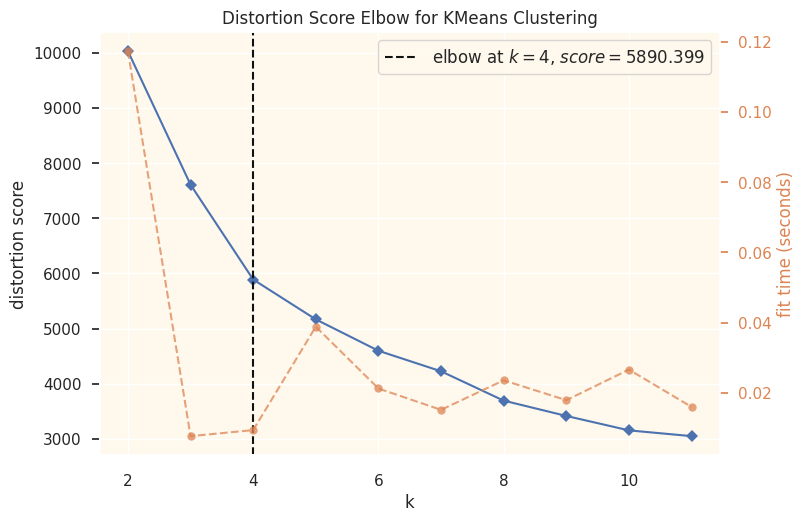

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [32]:
print('Elbow Method to determine the number of clusters to be formed:')
visualizer = KElbowVisualizer(KMeans(), k=11)
visualizer.fit(PCA_ds)
visualizer.show()

###7.2 K-means

In [33]:
KM = KMeans(n_clusters=4)
yhat_KM = KM.fit_predict(PCA_ds)

PCA_ds_KM = PCA_ds.copy()
data_KM = data.copy()
PCA_ds_KM["KM_Clusters"] = yhat_KM
data_KM["KM_Clusters"]= yhat_KM

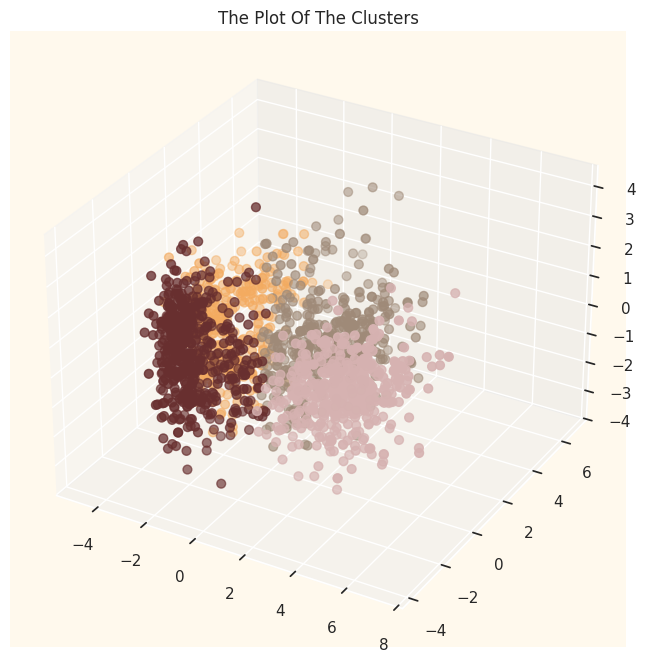

In [34]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds_KM["KM_Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

###7.3 Agglomerative clustering

In [35]:
AC = AgglomerativeClustering(n_clusters=4)
yhat_AC = AC.fit_predict(PCA_ds)

PCA_ds_AC = PCA_ds.copy()
data_AC = data.copy()
PCA_ds_AC["AC_Clusters"] = yhat_AC
data_AC["AC_Clusters"]= yhat_AC

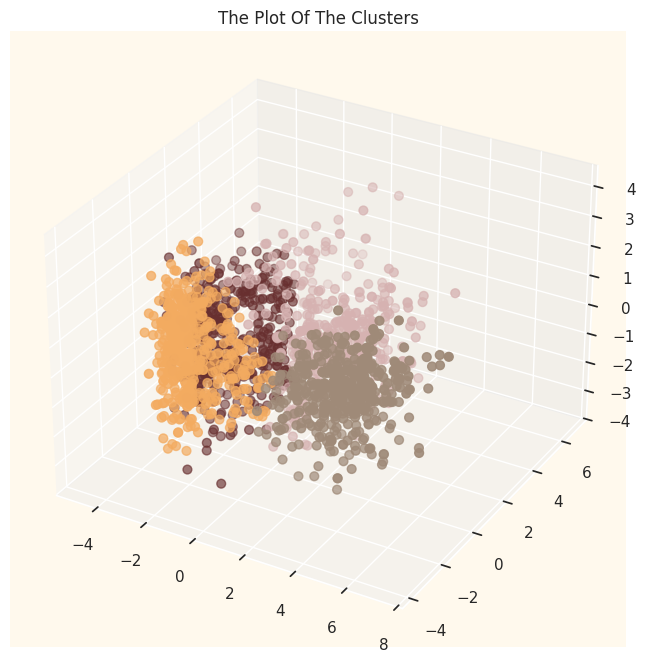

In [36]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds_AC["AC_Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

#8.Model Performance Evaluation

In [37]:
silhouette_KM = silhouette_score(PCA_ds, yhat_KM)
silhouette_AC = silhouette_score(PCA_ds, yhat_AC)
print(f"KMeans Silhouette Score: {silhouette_KM}")
print(f"Agglomerative Silhouette Score: {silhouette_AC}")

KMeans Silhouette Score: 0.3581728486137034
Agglomerative Silhouette Score: 0.33300973904486536


In [38]:
ch_KM = calinski_harabasz_score(PCA_ds, yhat_KM)
ch_AC = calinski_harabasz_score(PCA_ds, yhat_AC)
print(f"KMeans Calinski-Harabasz Score: {ch_KM}")
print(f"Agglomerative Calinski-Harabasz Score: {ch_AC}")

KMeans Calinski-Harabasz Score: 1425.8130134091953
Agglomerative Calinski-Harabasz Score: 1307.7583213195308


In [39]:
db_KM = davies_bouldin_score(PCA_ds, yhat_KM)
db_AC = davies_bouldin_score(PCA_ds, yhat_AC)
print(f"KMeans Davies-Bouldin Score: {db_KM}")
print(f"Agglomerative Davies-Bouldin Score: {db_AC}")

KMeans Davies-Bouldin Score: 1.0465575814692203
Agglomerative Davies-Bouldin Score: 1.1192885867082216


#9.Analysis and Insights

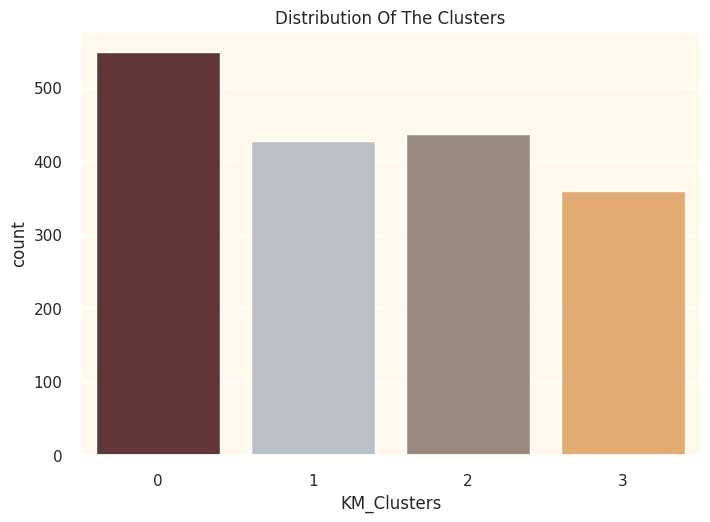

In [40]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data_KM["KM_Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

- scatter plot

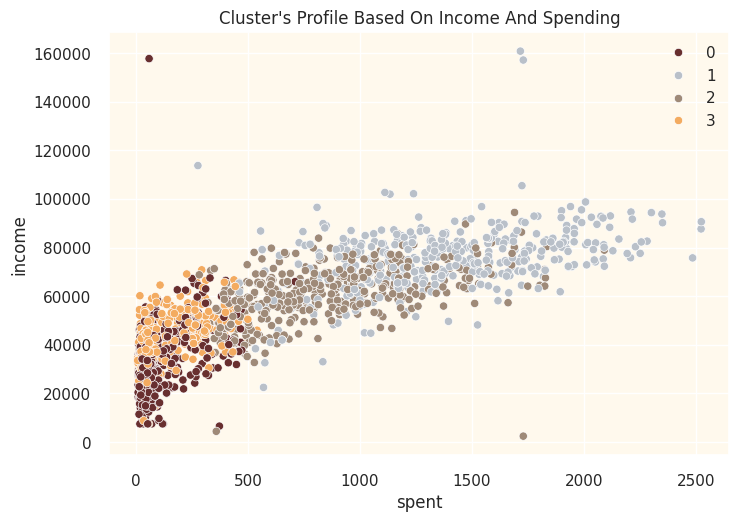

In [41]:
pl = sns.scatterplot(data=data_KM,x=data_KM["spent"], y=data_KM["income"],hue=data_KM["KM_Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

- Box plot

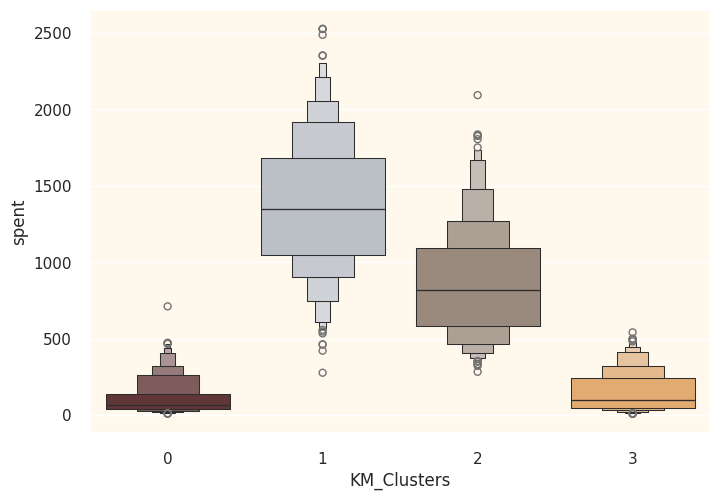

In [42]:
plt.figure()
pl=sns.boxenplot(x=data_KM["KM_Clusters"], y=data_KM["spent"], palette=pal)
plt.show()

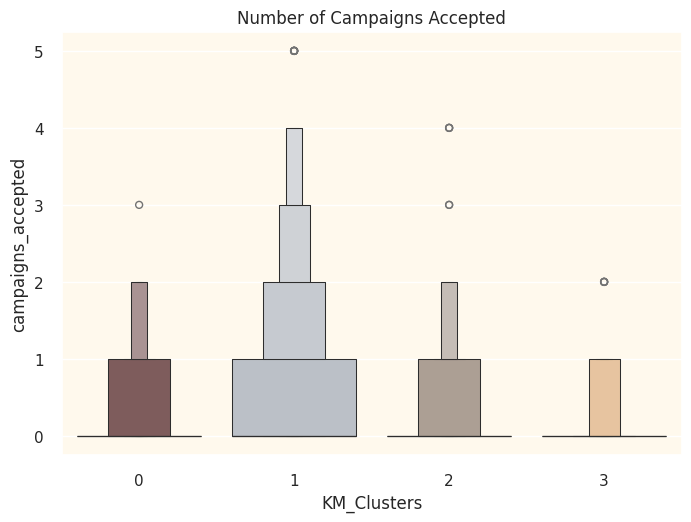

In [43]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data_KM["campaigns_accepted"],x=data_KM["KM_Clusters"], palette= pal)
pl.set_title("Number of Campaigns Accepted")
plt.show()

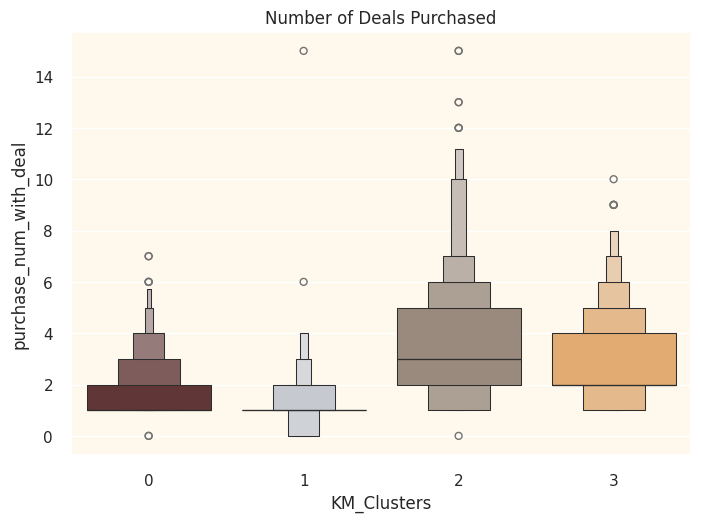

In [44]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data_KM["purchase_num_with_deal"],x=data_KM["KM_Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

- kernel density estimate (KDE) plot

<Figure size 800x550 with 0 Axes>

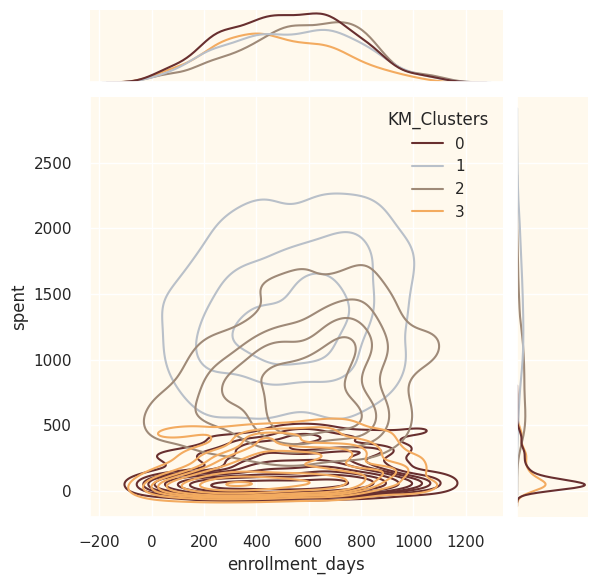

<Figure size 800x550 with 0 Axes>

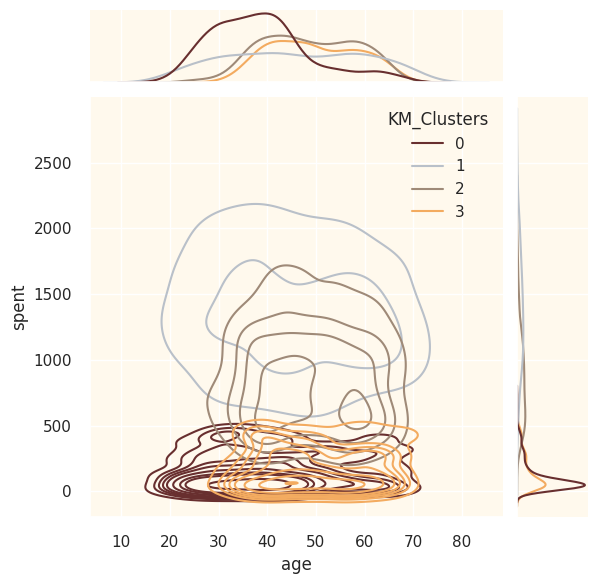

<Figure size 800x550 with 0 Axes>

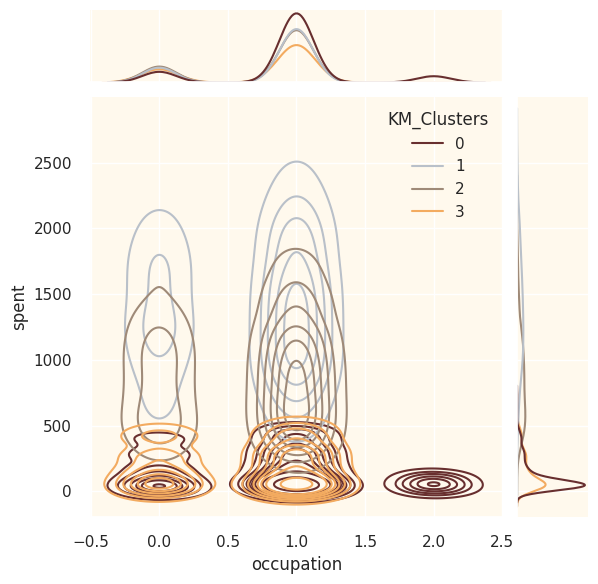

<Figure size 800x550 with 0 Axes>

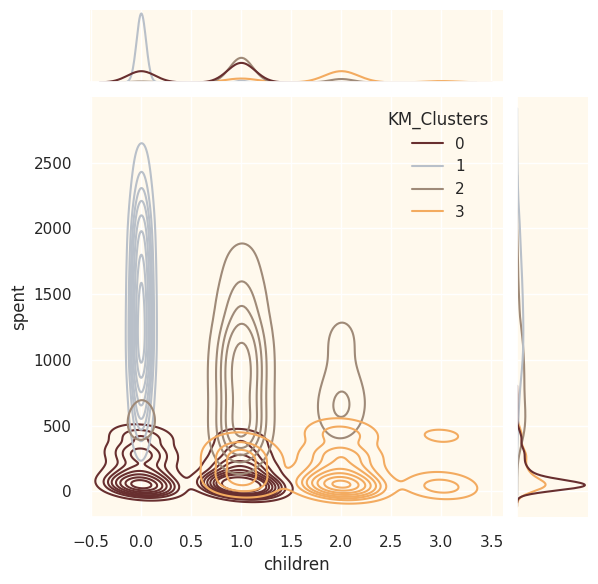

<Figure size 800x550 with 0 Axes>

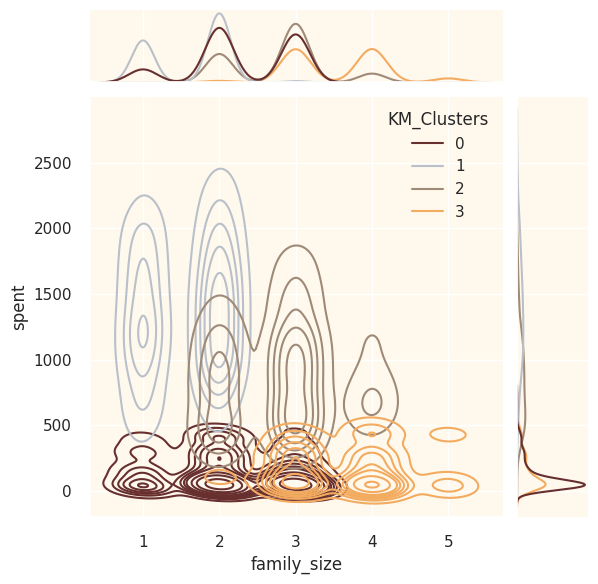

<Figure size 800x550 with 0 Axes>

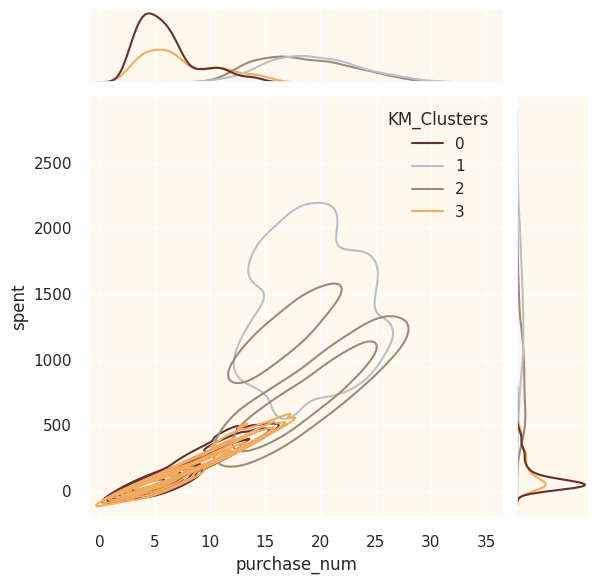

<Figure size 800x550 with 0 Axes>

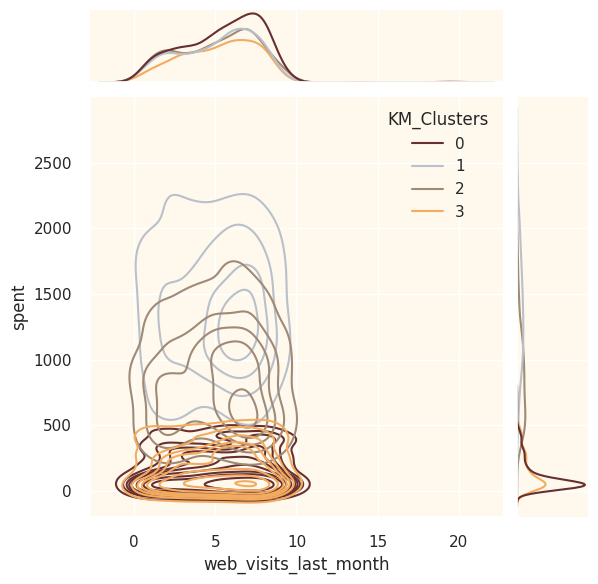

In [45]:
Personal = ["enrollment_days", "age", "occupation", "children", "family_size", 'purchase_num', 'web_visits_last_month']

for i in Personal:
    plt.figure()
    sns.jointplot(x=data_KM[i], y=data_KM["spent"], hue=data_KM["KM_Clusters"], kind="kde", palette=pal)
    plt.show()

In [46]:
means = data_KM.groupby(['KM_Clusters']).agg({
  'spent': 'mean',
  'income': 'mean',
  'family_size': 'mean',
  'age': 'mean',
  'campaigns_accepted': 'mean',
  'purchase_num': 'mean',
  'purchase_num_with_deal': 'mean',
})

# Calculate the count of records (rows) in each cluster
counts = data_KM['KM_Clusters'].value_counts().reset_index()
counts.columns = ['KM_Clusters', 'Count']

# Merge the mean and count DataFrames
result = pd.merge(means, counts, on='KM_Clusters')
result

KM_Clusters        spent        income  family_size        age  \
0            0   107.825137  32350.462659     2.302368  38.624772   
1            1  1372.640187  75630.299065     1.637850  45.890187   
2            2   862.592677  61451.913043     2.796339  48.572082   
3            3   151.019499  42235.069638     3.551532  49.565460   

   campaigns_accepted  purchase_num  purchase_num_with_deal  Count  
0            0.196721      6.067395                1.774135    549  
1            0.899533     19.364486                1.161215    428  
2            0.308924     18.432494                3.610984    437  
3            0.128134      7.342618                2.974930    359

**Cluster 0:**
- Total member of this cluster is 428
- Compared to other clusters, they have highest income and highest spent.
- Their Family Size is between 1 and 2 people.
- They are more likely to accept our campaigns.
- Even though they spend more, they have fewer deal purchases.

**Cluster 1:**
- Total member of this cluster is 370
- Compared to other clusters, they have low Income and low spending.
- Their Family Size is between 3 and 5 people.
- Their Age is over 30 years.
- They are unlikely to accept our campaigns.
- They have higher deal purchases.

**Cluster 2:**
- Total member of this cluster is 426
- Compared to other clusters, they have high income and high spent.
- Their Family Size is between 2 and 4 people.
- Their Age is over 30 years.
- They are less likely to accept our campaigns.
- they have higher deal purchases.

**Cluster 3:**
- Total member of this cluster is 549
- Compared to other clusters, they have lowest income and lowest spent.
- Their Family Size is between 1 and 3 people.
- They are less likely to accept our campaigns.
- they have lower deal purchases.

# 10.Deployment


- Model Export: Export the trained model into a deployable format.

- Dependency Analysis: Ensure that all dependencies required by the model, including libraries, runtime environments, and data preprocessing code, are available in the deployment environment.

- Performance Optimization: Optimize the model for performance, including techniques like model compression, quantization, and parallelization, to ensure high efficiency in the deployment environment.

- Deployment to Production Environment: Deploy the model to a production environment, choosing the appropriate deployment method such as a web service, container, or edge devices.

- Monitoring and Maintenance: Set up monitoring mechanisms to track the model's performance, accuracy, and stability in the production environment. Address issues such as model drift or performance degradation promptly to maintain the model's effectiveness.

- Security Considerations: Ensure the deployment meets security standards, including input data validation, preventing misuse of the model, and protecting the privacy of the model.

- Version Control: Implement version control for the model, allowing easy switching and rollback between model versions, ensuring flexibility to adapt to changes in the production environment.

